# LangGraph Agent Patterns - Building Effective Agents

This colab demonstrates common agent patterns from "Building effective agents" using the LangGraph framework. We'll implement several key patterns:
1. Memory-based Agent
2. Tool-using Agent  
3. Multi-agent Collaboration
4. Planning Agent

We'll use LangGraph's workflow system to build these patterns and integrate with LangSmith for tracing and debugging. For this demo, we'll use the free Gemini API from Google.

In [ ]:
# Install required dependencies
!pip install -q langgraph langsmith langchain langchain-google-genai langchain-community

# Import necessary libraries
import os
import json
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

# Configuration
os.environ["GOOGLE_API_KEY"] = ""  # Replace with your Gemini API key from Google AI Studio
os.environ["LANGCHAIN_TRACING_V2"] = ""  # Keep false unless you have LangSmith key

# Initialize LLM with Gemini
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.7,
    google_api_key=os.environ["GOOGLE_API_KEY"]
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 12.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sourc

## 1. Memory-based Agent Implementation

This agent maintains conversation history and context across interactions. It uses LangGraph's checkpointing mechanism to store state between calls, enabling the agent to remember previous interactions and provide contextual responses.

Key features:
- Persistent memory across sessions
- Context-aware responses
- State management with MemorySaver
- Uses free Gemini API

In [5]:
# Create a simple memory-based agent
from langgraph.graph import StateGraph, END
from typing import Annotated, TypedDict
import operator

# Define the state for our agent
class AgentState(TypedDict):
   messages: Annotated[list, operator.add]

# Create a simple agent that remembers context
def memory_agent(state: AgentState):
   # Get the last message
   last_message = state["messages"][-1]

   # Convert messages to string format for context
   context_str = "\n".join([f"{msg.__class__.__name__}: {msg.content}" for msg in state["messages"]])

   # Generate a response based on all previous messages
   prompt = f"Context of conversation:\n{context_str}\n\nCurrent message: {last_message.content}\n\nResponse:"
   response = llm.invoke(prompt)

   return {"messages": [AIMessage(content=response.content)]}

# Create the graph
memory_graph = StateGraph(AgentState)
memory_graph.add_node("agent", memory_agent)
memory_graph.set_entry_point("agent")
memory_graph.add_edge("agent", END)

# Compile with checkpointer for memory
memory_checkpointer = MemorySaver()
memory_compiled = memory_graph.compile(checkpointer=memory_checkpointer)

# Test the memory agent
config = {"configurable": {"thread_id": "test_thread"}}
result = memory_compiled.invoke(
   {"messages": [HumanMessage(content="My favorite color is blue")]},
   config=config
)
print("Agent:", result["messages"][-1].content)

# Test that it remembers
result2 = memory_compiled.invoke(
   {"messages": [HumanMessage(content="What's my favorite color?")]},
   config=config
)
print("Agent:", result2["messages"][-1].content)

Agent: That's a great choice! Blue is a very popular and versatile color. What do you like about blue?
Agent: You told me earlier that your favorite color is blue!


## 2. Tool-using Agent

This pattern demonstrates an agent that can use external tools to perform tasks. The agent uses Wikipedia as an example tool to retrieve information when needed.

Key features:
- Tool integration with LangGraph
- React-style reasoning (Thought-Action-Observation)
- Dynamic tool selection based on user queries
- Free Wikipedia API integration

In [8]:
# Create Wikipedia tool
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

# Define tool-using agent state
class ToolState(TypedDict):
   messages: Annotated[list, operator.add]

def tool_agent(state: ToolState):
   messages = state["messages"]
   last_message = messages[-1]

   # Create a simple tool-using agent
   if "search" in last_message.content.lower() or "find" in last_message.content.lower():
       # Extract search query
       search_query = last_message.content.replace("search for", "").replace("find", "").strip()

       # Use Wikipedia tool
       search_result = wikipedia.run(search_query)

       response = f"I searched for '{search_query}' and found:\n\n{search_result}"
   else:
       # Regular response
       response = llm.invoke(last_message.content)
       response = response.content

   return {"messages": [AIMessage(content=response)]}

# Create tool agent graph
tool_graph = StateGraph(ToolState)
tool_graph.add_node("agent", tool_agent)
tool_graph.set_entry_point("agent")
tool_graph.add_edge("agent", END)

# Compile and test
tool_compiled = tool_graph.compile()

# Test tool usage
result = tool_compiled.invoke({"messages": [HumanMessage(content="search for Albert Einstein")]})
print("Tool Agent:", result["messages"][-1].content)

# Test normal conversation
result2 = tool_compiled.invoke({"messages": [HumanMessage(content="Tell me a joke")]})
print("Tool Agent:", result2["messages"][-1].content)

Tool Agent: I searched for 'Albert Einstein' and found:

Page: Albert Einstein
Summary: Albert Einstein (14 March 1879 – 18 April 1955) was a German-born theoretical physicist who is best known for developing the theory of relativity. Einstein also made important contributions to quantum mechanics. His mass–energy equivalence formula E = mc2, which arises from special relativity, has been called "the world's most famous equation". He received the 1921 Nobel Prize in Physics for his services to theoretical physics, and especially for his discovery of the law of the photoelectric effect.
Born in the German Empire, Einstein moved to Switzerland in 1895, forsaking his German citizenship (as a subject of the Kingdom of Württemberg) the following year. In 1897, at the age of seventeen, he enrolled in the mathematics and physics teaching diploma program at the Swiss federal polytechnic school in Zurich, graduating in 1900. He acquired Swiss citizenship a year later, which he kept for the rest

## 3. Multi-agent Collaboration

This pattern shows how multiple specialized agents can work together on a task. Each agent has a specific role and they pass information between themselves to complete complex tasks.

Key features:
- Multiple specialized agents
- Agent collaboration workflow
- State sharing between agents
- Task delegation and coordination

In [9]:
# Define multi-agent state
class MultiAgentState(TypedDict):
   messages: Annotated[list, operator.add]
   task_type: str
   current_agent: str
   result: str

# Create specialized agents
def researcher_agent(state: MultiAgentState):
   """Researches information using Wikipedia"""
   task = state["messages"][-1].content

   if "research" in task.lower() or "find information" in task.lower():
       search_query = task.split("about")[-1].strip() if "about" in task else task
       research_result = wikipedia.run(search_query)

       response = f"Research findings: {research_result}"
       return {"messages": [AIMessage(content=response)], "current_agent": "writer", "result": research_result}

   return {"messages": [AIMessage(content="No research task identified")], "current_agent": "done"}

def writer_agent(state: MultiAgentState):
   """Writes content based on research"""
   research_result = state.get("result", "")

   if research_result:
       prompt = f"Based on this research: {research_result}\n\nWrite a brief summary:"
       response = llm.invoke(prompt)
       return {"messages": [AIMessage(content=response.content)], "current_agent": "done"}

   return {"messages": [AIMessage(content="No research data to write from")], "current_agent": "done"}

# Create multi-agent workflow
multi_agent_graph = StateGraph(MultiAgentState)
multi_agent_graph.add_node("researcher", researcher_agent)
multi_agent_graph.add_node("writer", writer_agent)

# Set entry point
multi_agent_graph.set_entry_point("researcher")

# Add conditional edges
def router(state: MultiAgentState):
   if state["current_agent"] == "writer":
       return "writer"
   else:
       return END

multi_agent_graph.add_conditional_edges("researcher", router, {"writer": "writer", END: END})
multi_agent_graph.add_edge("writer", END)

# Compile and test
multi_agent = multi_agent_graph.compile()

# Test multi-agent collaboration
result = multi_agent.invoke({
   "messages": [HumanMessage(content="research about quantum computing")],
   "task_type": "research_and_write",
   "current_agent": "researcher",
   "result": ""
})

print("Multi-Agent Result:")
for msg in result["messages"]:
   print(f"{msg.__class__.__name__}: {msg.content}")

Multi-Agent Result:
HumanMessage: research about quantum computing
AIMessage: Research findings: Page: Quantum computing
Summary: A quantum computer is a computer that exploits quantum mechanical phenomena. On small scales, physical matter exhibits properties of both particles and waves, and quantum computing takes advantage of this behavior using specialized hardware. Classical physics cannot explain the operation of these quantum devices, and a scalable quantum computer could perform some calculations exponentially faster than any modern "classical" computer. Theoretically a large-scale quantum computer could break some widely used encryption schemes and aid physicists in performing physical simulations; however, the current state of the art is largely experimental and impractical, with several obstacles to useful applications.
The basic unit of information in quantum computing, the qubit (or "quantum bit"), serves the same function as the bit in classical computing. However, unlike 

## 4. Planning Agent

This pattern demonstrates an agent that can break down complex tasks into steps and execute them systematically. The planning agent creates a plan of action and then executes each step sequentially.

Key features:
- Task decomposition
- Sequential execution
- Step-by-step tracking
- Goal-oriented behavior

In [10]:
# Define planning agent state
class PlanningState(TypedDict):
   messages: Annotated[list, operator.add]
   plan: list
   current_step: int
   step_results: list

def planning_agent(state: PlanningState):
   """Creates a plan for complex tasks"""
   task = state["messages"][-1].content

   # Generate a plan
   prompt = f"""Break down this task into 3-5 simple steps: {task}

Format your response as a numbered list:
1. [step]
2. [step]
3. [step]"""

   plan_response = llm.invoke(prompt)

   # Extract plan steps
   plan_text = plan_response.content
   steps = []
   for line in plan_text.split('\n'):
       if line.strip() and any(line.strip().startswith(str(i)) for i in range(1, 6)):
           steps.append(line.strip())

   return {
       "messages": [AIMessage(content=f"Created plan:\n{plan_text}")],
       "plan": steps,
       "current_step": 0,
       "step_results": []
   }

def execute_step(state: PlanningState):
   """Executes the current step in the plan"""
   if state["current_step"] >= len(state["plan"]):
       final_summary = "\n".join(state["step_results"])
       return {
           "messages": [AIMessage(content=f"Plan completed. Results:\n{final_summary}")],
           "current_step": state["current_step"]
       }

   current_step = state["plan"][state["current_step"]]

   # Execute current step
   prompt = f"Execute this step: {current_step}\nProvide a brief result."
   result = llm.invoke(prompt)

   return {
       "messages": [AIMessage(content=f"Executed: {current_step}\nResult: {result.content}")],
       "current_step": state["current_step"] + 1,
       "step_results": state["step_results"] + [f"Step {state['current_step'] + 1}: {result.content}"]
   }

# Create planning agent workflow
planning_graph = StateGraph(PlanningState)
planning_graph.add_node("planner", planning_agent)
planning_graph.add_node("executor", execute_step)

planning_graph.set_entry_point("planner")
planning_graph.add_edge("planner", "executor")

# Add loop for executing all steps
def should_continue(state: PlanningState):
   if state["current_step"] >= len(state["plan"]):
       return END
   return "executor"

planning_graph.add_conditional_edges("executor", should_continue, {"executor": "executor", END: END})

# Compile and test
planning_compiled = planning_graph.compile()

# Test planning agent
result = planning_compiled.invoke({
   "messages": [HumanMessage(content="Plan and execute: Create a simple chatbot")],
   "plan": [],
   "current_step": 0,
   "step_results": []
})

print("Planning Agent Results:")
for msg in result["messages"]:
   print(f"\n{msg.__class__.__name__}: {msg.content}")

Planning Agent Results:

HumanMessage: Plan and execute: Create a simple chatbot

AIMessage: Created plan:
Here's a breakdown of the task into simple steps:

1.  **Define the Chatbot's Purpose & Scope:** Decide what the chatbot will do. Will it answer FAQs, provide customer support, or something else? Keep it simple for a first project (e.g., answering a set of pre-defined questions).
2.  **Choose a Platform/Tool & Design the Conversation Flow:** Select a chatbot building platform (e.g., Dialogflow, Rasa, or a simpler text-based option using Python). Design the basic conversational flow, mapping out possible user inputs and the chatbot's responses.
3.  **Train/Program the Chatbot & Test:** Implement the conversation flow within your chosen platform. "Train" the chatbot with example phrases for each intent (if using AI-based platforms). Thoroughly test the chatbot by asking different questions and observing its responses.

AIMessage: Executed: 1.  **Define the Chatbot's Purpose & Scope:

## Summary and Testing

Let's create a simple test dashboard to demonstrate all agent patterns and visualize their execution flow:

- Memory-based Agent: Maintains conversation context
- Tool-using Agent: Integrates external APIs
- Multi-agent Collaboration: Coordinates multiple specialized agents
- Planning Agent: Breaks down and executes complex tasks

This completes the LangGraph implementation. For the CrewAI implementation, we'll need to structure the patterns differently using CrewAI's framework.

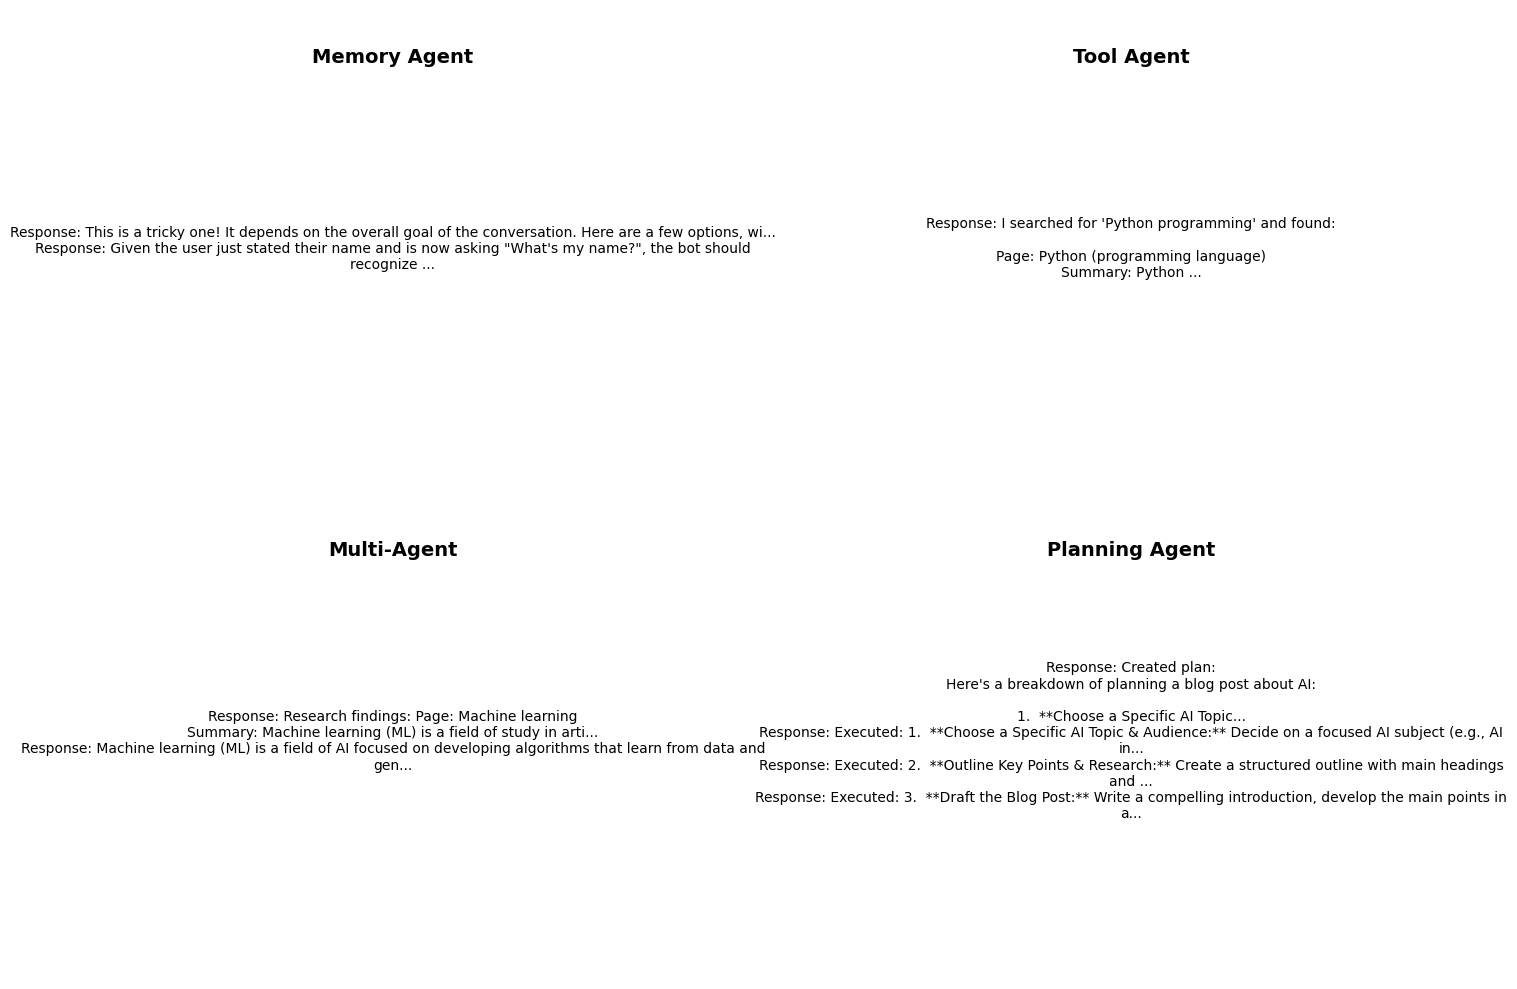


=== LangGraph Agent Patterns Summary ===

Memory Agent:
  Response 1: This is a tricky one! It depends on the overall goal of the conversation. Here are a few options, with explanations:

**Option 1 (Most likely - Assuming the bot should acknowledge and move on):**

> O...
  Response 2: Given the user just stated their name and is now asking "What's my name?", the bot should recognize the user is likely testing its memory or engaging in a lighthearted exchange. Here are a few options...

Tool Agent:
  Response 1: I searched for 'Python programming' and found:

Page: Python (programming language)
Summary: Python is a high-level, general-purpose programming language. Its design philosophy emphasizes code readabi...

Multi-Agent:
  Response 1: Research findings: Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can lear...
  Response 2: Machine learning (ML) is a fie

In [11]:
# Create a test dashboard to demonstrate all patterns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create visualization of agent patterns
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2, figure=fig)

# Test all patterns and visualize
patterns = {
   "Memory Agent": memory_compiled,
   "Tool Agent": tool_compiled,
   "Multi-Agent": multi_agent,
   "Planning Agent": planning_compiled
}

test_queries = {
   "Memory Agent": ["My name is Alice", "What's my name?"],
   "Tool Agent": ["search for Python programming"],
   "Multi-Agent": ["research about machine learning"],
   "Planning Agent": ["Plan: write a blog post about AI"]
}

results = {}

# Test each pattern
for pattern_name, agent in patterns.items():
   if pattern_name == "Memory Agent":
       config = {"configurable": {"thread_id": "demo_thread"}}
       result1 = agent.invoke({"messages": [HumanMessage(content=test_queries[pattern_name][0])]}, config=config)
       result2 = agent.invoke({"messages": [HumanMessage(content=test_queries[pattern_name][1])]}, config=config)
       results[pattern_name] = [result1["messages"][-1].content, result2["messages"][-1].content]
   else:
       if pattern_name == "Multi-Agent":
           result = agent.invoke({
               "messages": [HumanMessage(content=test_queries[pattern_name][0])],
               "task_type": "research_and_write",
               "current_agent": "researcher",
               "result": ""
           })
           results[pattern_name] = [msg.content for msg in result["messages"] if isinstance(msg, AIMessage)]
       elif pattern_name == "Planning Agent":
           result = agent.invoke({
               "messages": [HumanMessage(content=test_queries[pattern_name][0])],
               "plan": [],
               "current_step": 0,
               "step_results": []
           })
           results[pattern_name] = [msg.content for msg in result["messages"] if isinstance(msg, AIMessage)]
       else:
           result = agent.invoke({"messages": [HumanMessage(content=test_queries[pattern_name][0])]})
           results[pattern_name] = [result["messages"][-1].content]

# Display results
for i, (pattern_name, pattern_results) in enumerate(results.items()):
   ax = fig.add_subplot(gs[i // 2, i % 2])
   ax.text(0.5, 0.9, pattern_name, ha='center', va='center', fontsize=14, fontweight='bold')

   result_text = "\n".join([f"Response: {r[:100]}..." if len(r) > 100 else f"Response: {r}" for r in pattern_results])
   ax.text(0.5, 0.5, result_text, ha='center', va='center', fontsize=10, wrap=True)
   ax.set_xlim(0, 1)
   ax.set_ylim(0, 1)
   ax.axis('off')

plt.tight_layout()
plt.show()

# Print summary
print("\n=== LangGraph Agent Patterns Summary ===")
for pattern_name, pattern_results in results.items():
   print(f"\n{pattern_name}:")
   for j, result in enumerate(pattern_results):
       print(f"  Response {j+1}: {result[:200]}...")